# Processing Movement Data

The code of this particular notebook is an adaptation of the MATLAB code developed by <br>Zimmermann, M., Lomoriello, A. S., & Konvalinka, I. (2022). Intra-individual behavioural and neural signatures of audience effects and interactions in a mirror-game paradigm. Royal Society Open Science, 9(2), 211352.

The MATLAB code is openly available here: https://osf.io/5nt8f/

Procedure:<br>
For each participant, missing samples are interpolated using shape-preserving piecewise cubic interpolation (‘pchip’ method in interp1, Matlab). Next, position over time is transformed into one-dimensional data, and data are segmented into trials and smoothed using a 100 ms centred moving average.

In [1]:
### Importing packages

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import urllib
import re
import scipy
import math
import pathlib
import glob, os
from scipy import interpolate
from os.path import join
from os import listdir

In [2]:
### Loading the data

pair_n = "003"
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

for i in listdir(folder):
    match1 = re.search(r"logfile_20.+?.txt", i)
    match2 = re.search(r"logfile_trialorder.+?.txt", i)
    match3 = re.search(r"logfile_rating.+?.txt", i)
    match4 = re.search(r"polhemus.+?.csv", i)
    if match1:
        logfile = pd.read_csv(join(folder, i), sep=';', index_col=False, names=[0,1,2,3])
    elif match2:
        trialorder = pd.read_csv(join(folder, i), sep=',', names=[0,1,2])
    elif match3:
        rating = pd.read_csv(join(folder, i), sep=';',names=[0,1,2,3,4,5])
    elif match4:
        polhemusdata = pd.read_csv(join(folder, i))

In [3]:
### Splitting data for each participant

polhemus_p1 = polhemusdata.loc[polhemusdata['Sensor'] == 2]
polhemus_p2 = polhemusdata.loc[polhemusdata['Sensor'] == 1]

In [4]:
### Interpolating missing samples for participants 1 & 2

recsamples = list(polhemus_p1["Sample"]) ### recorded samples
allsamples = list(range(polhemus_p1.iloc[0,1], (polhemus_p1.iloc[-1,1]+1))) ### needed samples

polhemus_fix_p1 = {}
polhemus_fix_p2 = {}

# P1

polhemus_fix_p1["Sample"] = allsamples
polhemus_fix_p1["Timestamp"] = [round(x) for x in 
                                interpolate.interp1d(recsamples, polhemus_p1['Timestamp'])(allsamples)]
polhemus_fix_p1["Marker"] = [round(x) for x in 
                             interpolate.interp1d(recsamples, polhemus_p1['Marker'])(allsamples)]

polhemus_fix_p1["Position X"] = interpolate.PchipInterpolator(recsamples, polhemus_p1['Position X'])(allsamples)
polhemus_fix_p1["Position Y"] = interpolate.PchipInterpolator(recsamples, polhemus_p1['Position Y'])(allsamples)
polhemus_fix_p1["Position Z"] = interpolate.PchipInterpolator(recsamples, polhemus_p1['Position Z'])(allsamples)

# P2

polhemus_fix_p2["Sample"] = allsamples
polhemus_fix_p2["Timestamp"] = [round(x) for x in 
                                interpolate.interp1d(recsamples, polhemus_p2['Timestamp'])(allsamples)]
polhemus_fix_p2["Marker"] = [round(x) for x in 
                             interpolate.interp1d(recsamples, polhemus_p2['Marker'])(allsamples)]

polhemus_fix_p2["Position X"] = interpolate.PchipInterpolator(recsamples, polhemus_p2['Position X'])(allsamples)
polhemus_fix_p2["Position Y"] = interpolate.PchipInterpolator(recsamples, polhemus_p2['Position Y'])(allsamples)
polhemus_fix_p2["Position Z"] = interpolate.PchipInterpolator(recsamples, polhemus_p2['Position Z'])(allsamples)

In [5]:
### Transforming position over time into 1D

polhemus_fix_p1["Position"] = [np.sqrt(x**2+y**2+z**2)
                               for x,y,z 
                               in zip(polhemus_fix_p1["Position X"],
                                      polhemus_fix_p1["Position Y"],
                                      polhemus_fix_p1["Position Z"])]  

polhemus_fix_p2["Position"] = [np.sqrt(x**2+y**2+z**2)
                               for x,y,z 
                               in zip(polhemus_fix_p2["Position X"],
                                      polhemus_fix_p2["Position Y"],
                                      polhemus_fix_p2["Position Z"])]  

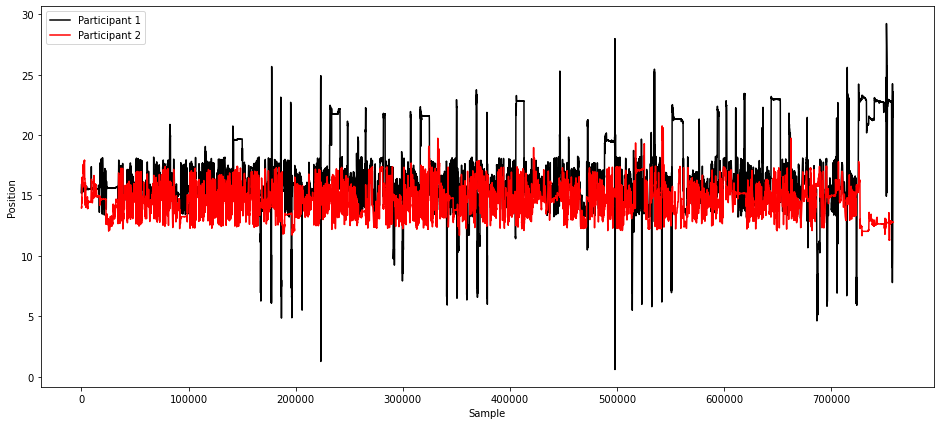

In [6]:
### Visualizing 1D positions

plt.figure(figsize=(16, 7))

plt.plot(polhemus_fix_p1["Sample"],polhemus_fix_p1["Position"], label="Participant 1", color = 'black')
plt.plot(polhemus_fix_p2["Sample"],polhemus_fix_p2["Position"], label="Participant 2", color = 'red')
plt.xlabel('Sample')
plt.ylabel('Position')

plt.legend()
plt.show()

In [7]:
### Enhancing trial markers

# Participant 1

polhemus_fix_ppn1 = pd.DataFrame(polhemus_fix_p1)
polhemus_fix_ppn1["New Marker"] = polhemus_fix_ppn1["Marker"]

onsets_tmp_ppn1 = polhemus_fix_ppn1.loc[polhemus_fix_ppn1["Marker"]==0,["Sample","Timestamp","Marker"]]
onsets_diff = np.diff(onsets_tmp_ppn1.iloc[:,1])

markdifflim = 1500
for i in range(0,len(onsets_diff)):
    if onsets_diff[i]<markdifflim:
        polhemus_fix_ppn1.iloc[
            range(
                int(np.where(polhemus_fix_ppn1["Sample"]==onsets_tmp_ppn1.iloc[i,0])[0]),
                int(np.where(polhemus_fix_ppn1["Sample"]==onsets_tmp_ppn1.iloc[i+1,0])[0])
            ),
            -1] = 0


# Participant 2
        
polhemus_fix_ppn2 = pd.DataFrame(polhemus_fix_p2)

In [8]:
print(sum(polhemus_fix_ppn1["New Marker"]) < sum(polhemus_fix_ppn1["Marker"]))
print(len(polhemus_fix_ppn1["New Marker"]) == len(polhemus_fix_ppn1["Marker"]))
print(sum(polhemus_fix_ppn1["New Marker"]))

True
True
640131


In [9]:
### Removing short markers

allzero = np.where(polhemus_fix_ppn1["New Marker"] == 0)[0].tolist()
c = 0
for i in range(1,len(allzero)):
    if ((allzero[i]-allzero[i-1])==1):
        c=c+1
    else:
        if c<500:
            polhemus_fix_ppn1.iloc[
                range(
                    int(np.where(polhemus_fix_ppn1["Sample"]==allzero[i-c])[0]),
                    int(np.where(polhemus_fix_ppn1["Sample"]==allzero[i])[0])
                ),
                -1] = 1
        else:
            c=0

In [10]:
print(sum(polhemus_fix_ppn1["New Marker"]))

651285


In [11]:
### Retrieving trial onsets

trial_onsets = [x+1 for x in np.where(np.diff(polhemus_fix_ppn1["New Marker"]==1))][0].tolist()

# Since even onsets mean preparatory period, we need to take only odd onsets

trial_onsets_odd = trial_onsets[1::2]

In [12]:
### Grouping the data by trial


# Participant 1

polhemus1 = []

for i in range(0, len(trial_onsets_odd)-1): ### dropping the last marker (the 83rd)
    if i in [0,81]:
        polhemus1.append(list(polhemus_fix_ppn1.iloc[range(trial_onsets_odd[i],(trial_onsets_odd[i]+120*240)),6]))
    else:
        polhemus1.append(list(polhemus_fix_ppn1.iloc[range(trial_onsets_odd[i],(trial_onsets_odd[i]+26*240)),6]))

        
# Participant 2        
        
polhemus2 = []

for i in range(0, len(trial_onsets_odd)-1): ### dropping the last marker (the 83rd)
    if i in [0,81]:
        polhemus2.append(list(polhemus_fix_ppn2.iloc[range(trial_onsets_odd[i],(trial_onsets_odd[i]+120*240)),6]))
    else:
        polhemus2.append(list(polhemus_fix_ppn2.iloc[range(trial_onsets_odd[i],(trial_onsets_odd[i]+26*240)),6]))

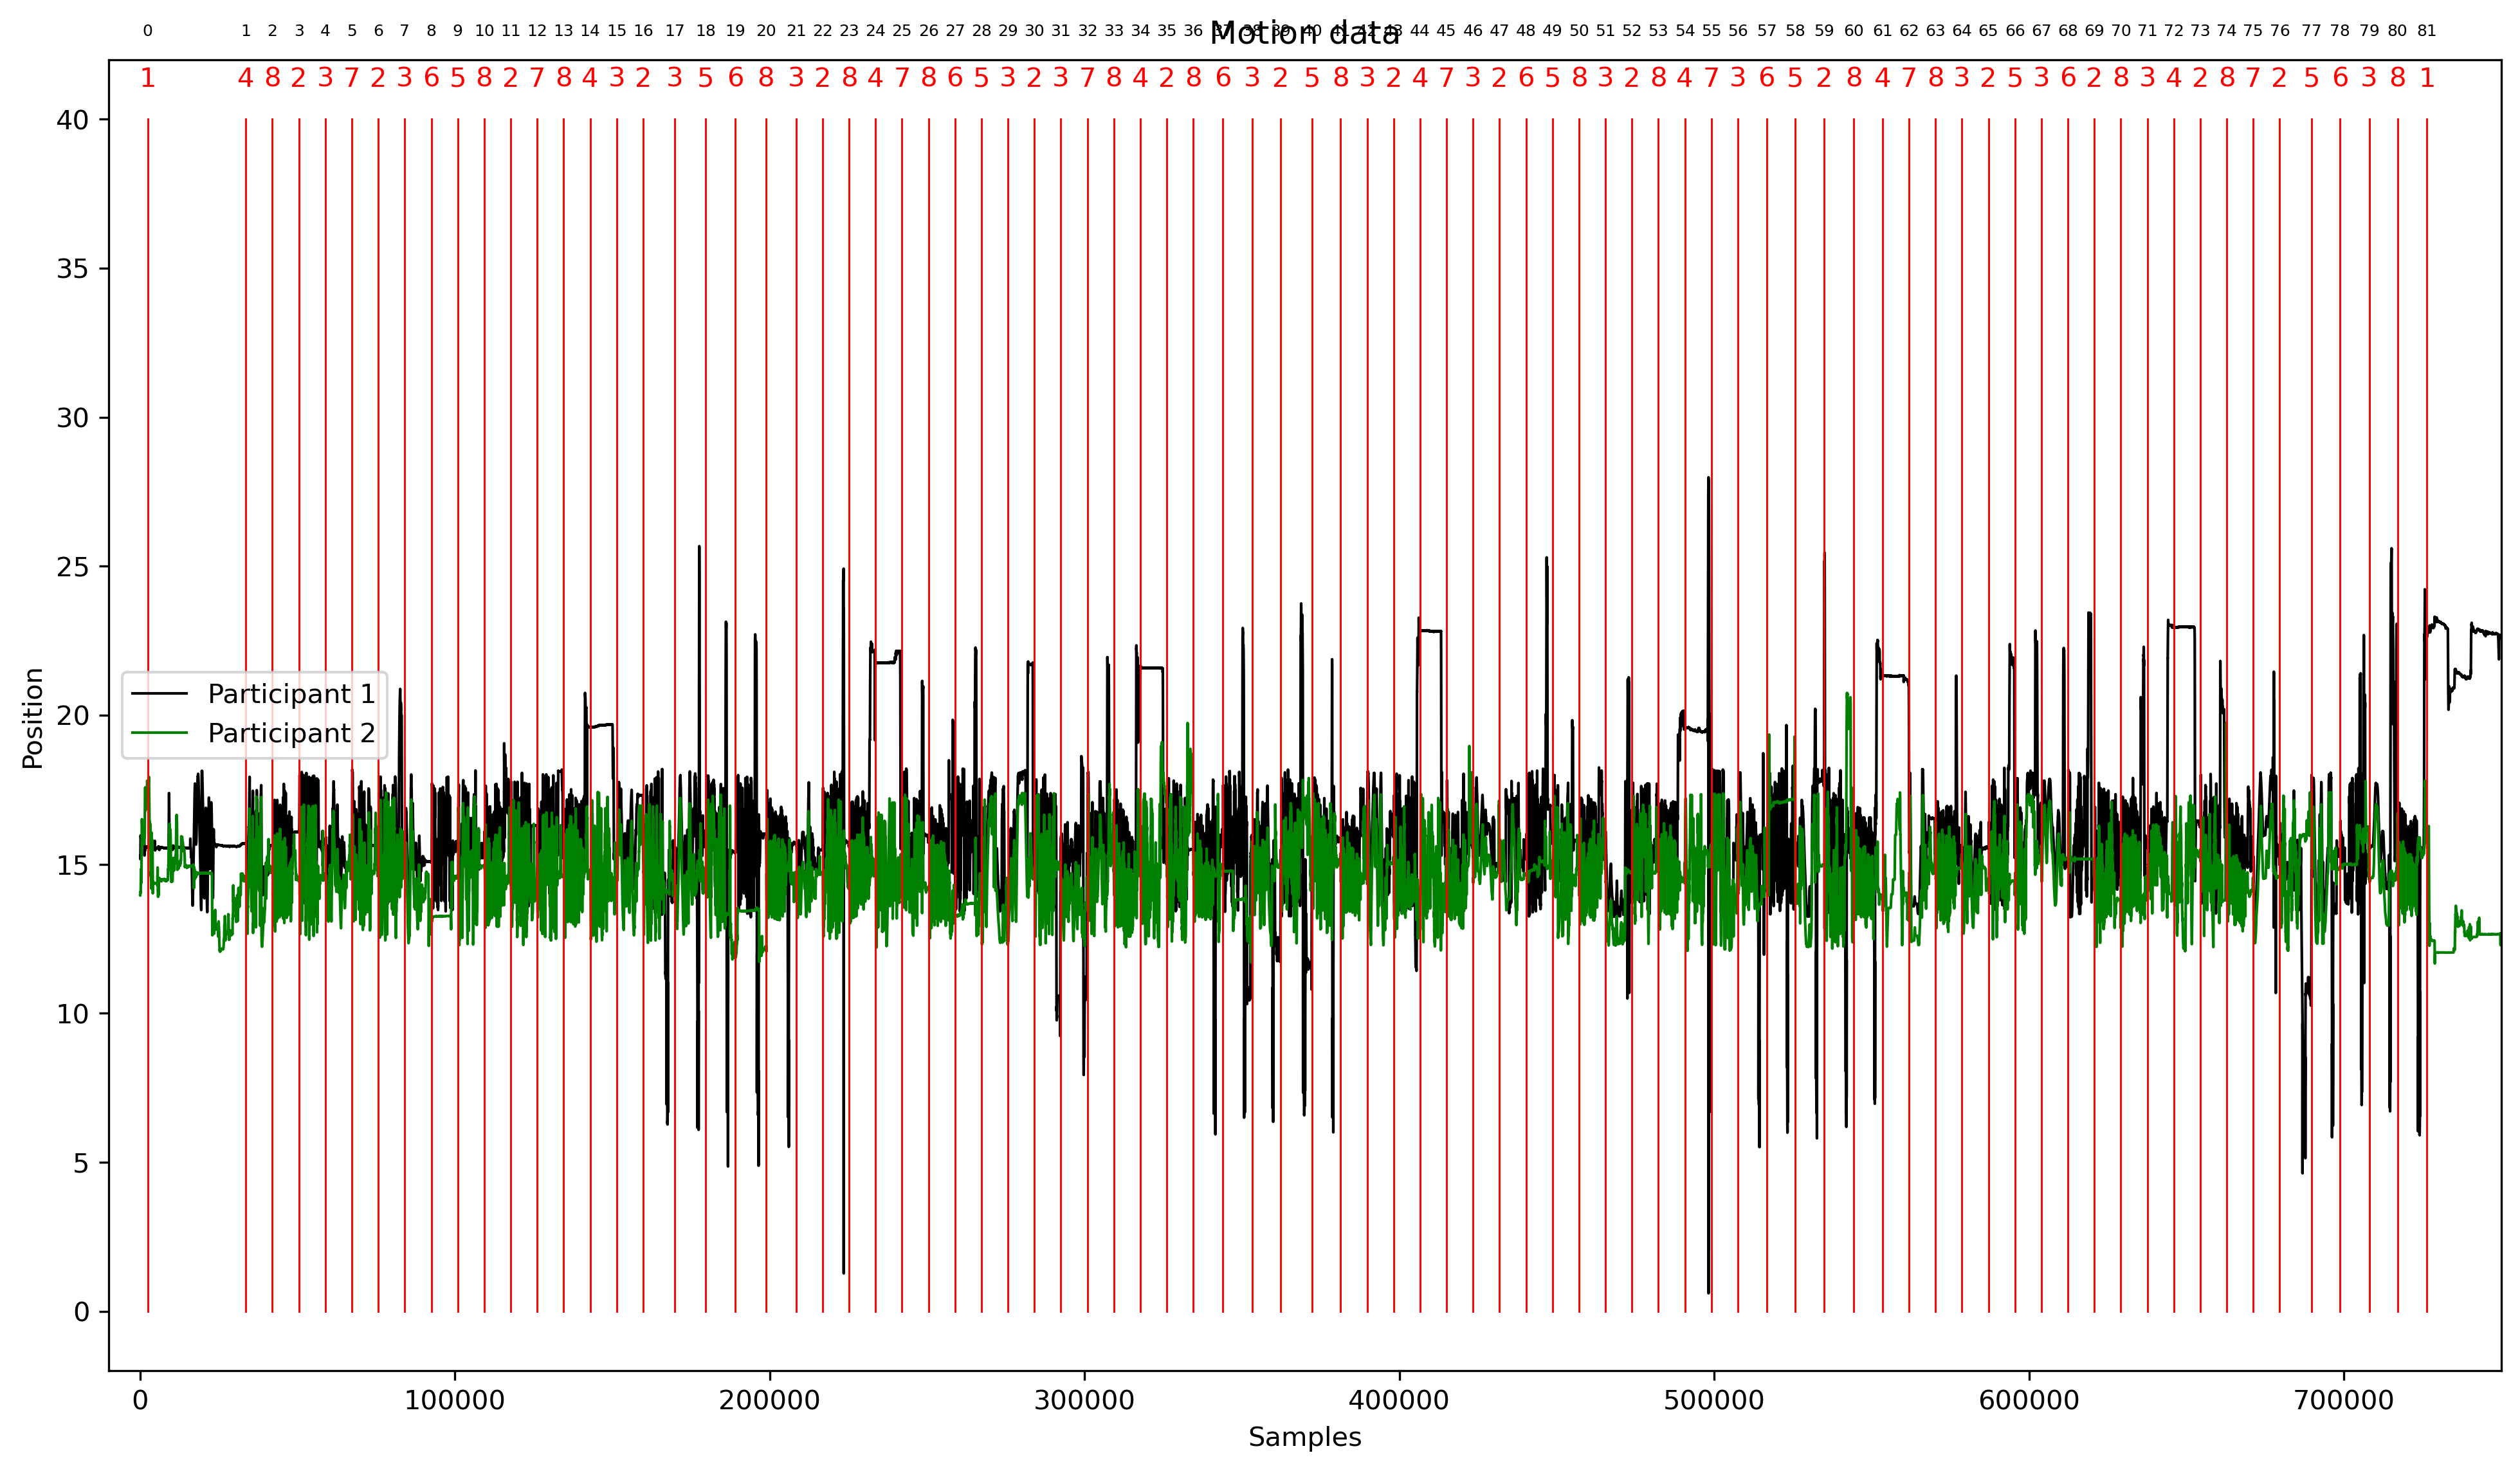

In [13]:
### Visualizing

plt.figure(figsize=(16, 9), dpi=300)

plt.plot(polhemus_fix_ppn1["Sample"],polhemus_fix_ppn1["Position"], 
         label="Participant 1", color = 'black', linewidth=1)
plt.plot(polhemus_fix_ppn2["Sample"],polhemus_fix_ppn2["Position"], 
         label="Participant 2", color = 'green', linewidth=1)
plt.plot([trial_onsets_odd,trial_onsets_odd], [[0]*len(trial_onsets_odd),
         [40]*len(trial_onsets_odd)],
         color='red', linewidth=0.7)
plt.xlim(-10000,750000)
plt.xlabel('Samples')
plt.ylabel('Position')

for label, x, y in zip([str(x) for x in list(trialorder[0])], trial_onsets_odd, [40]*len(trial_onsets_odd)):
       plt.annotate(
          f"{label}",
          xy=(x, y), xytext=(0, 10),
          textcoords='offset points', ha='center', va='bottom', color = 'red')

for label, x, y in zip([str(x) for x in range(0,82)], trial_onsets_odd, [40]*len(trial_onsets_odd)):
       plt.annotate(
          f"{label}",
          xy=(x, y), xytext=(0, 30),
          textcoords='offset points', ha='center', va='bottom', color = 'black', 
          font = {'family':'sans','size': 6})

plt.title("Motion data")

plt.legend()
plt.show()

<b>Note:</b><br>
Small black numbers stand for the trial number. Bigger red numbers mean condition codes for participant 1:<br>
    
    'rest': 1
    'individual': 2,
    'coupled': 3,
    'actor': 6,
    'observer': 4,
    'leader':7,
    'follower':5,
    'control': 8

In [18]:
### Setting what trials need checking whether participants moved when they were not supposed to

checklist = [y for x,y in zip(list(trialorder[0]), list(range(0,82))) if x in [3]]
print(f"Check the following trials:\n{checklist}")

Check the following trials:
[4, 7, 15, 17, 21, 29, 31, 38, 42, 46, 51, 56, 64, 67, 71, 79]


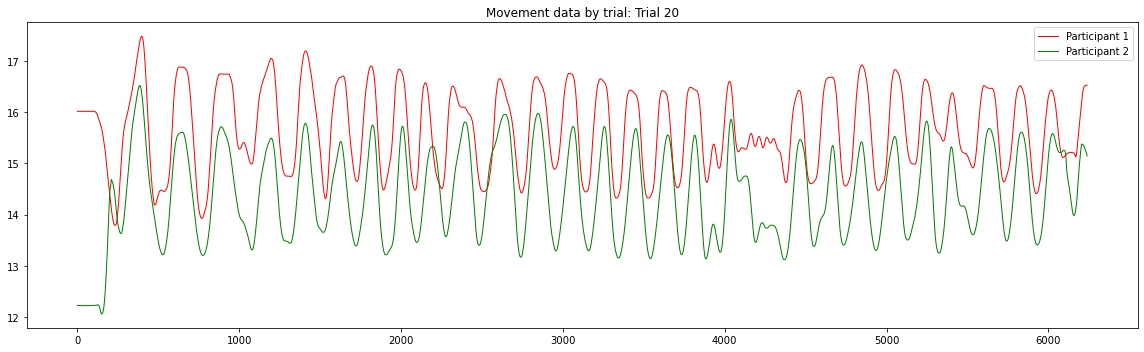

In [17]:
### Checking trial by trial

trial_number = 20

fig, ax1 = plt.subplots(1, 1, figsize=(16, 5))

ax1.plot(polhemus1[trial_number], color = 'red', linewidth =1, label = 'Participant 1')
ax1.plot(polhemus2[trial_number], color = 'green', linewidth =1, label = 'Participant 2')
ax1.set_title(f"Movement data by trial: Trial {trial_number}")

plt.legend()
plt.tight_layout()
plt.show()